- RNN: Recurrent Neural Network
- LSTM: Long Short Term Memory
- ES: Early Stopping
- Multi-Step time series forecasting
- Univariate (only input its own price)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation
import datetime
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from keras.callbacks import EarlyStopping
import seaborn as sns

In [2]:
# reading csv
dataset = pd.read_csv('yahoo_BTC-USD.csv')
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864,468.174,452.422,457.334,457.334,21056800.000
1,2014-09-18,456.860,456.860,413.104,424.440,424.440,34483200.000
2,2014-09-19,424.103,427.835,384.532,394.796,394.796,37919700.000
3,2014-09-20,394.673,423.296,389.883,408.904,408.904,36863600.000
4,2014-09-21,408.085,412.426,393.181,398.821,398.821,26580100.000
...,...,...,...,...,...,...,...
2449,2021-06-01,37293.793,37896.734,35787.086,36684.926,36684.926,34639423297.000
2450,2021-06-02,36699.922,38231.340,35966.309,37575.180,37575.180,33070867190.000
2451,2021-06-03,37599.410,39478.953,37243.973,39208.766,39208.766,35460750427.000
2452,2021-06-04,39242.484,39242.484,35717.723,36894.406,36894.406,41831090187.000


In [3]:
dataset[['Close','Volume']].corr()

,Close,Volume
Close,1.000,0.798
Volume,0.798,1.000


In [4]:
# checking if close is not equal to adj close
dataset[dataset['Close']!=dataset['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
2039,2020-04-17,nan,nan,nan,nan,nan,nan
2214,2020-10-09,nan,nan,nan,nan,nan,nan
2217,2020-10-12,nan,nan,nan,nan,nan,nan
2218,2020-10-13,nan,nan,nan,nan,nan,nan


In [5]:
# checking for nulls
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2454 non-null   object 
 1   Open       2450 non-null   float64
 2   High       2450 non-null   float64
 3   Low        2450 non-null   float64
 4   Close      2450 non-null   float64
 5   Adj Close  2450 non-null   float64
 6   Volume     2450 non-null   float64
dtypes: float64(6), object(1)
memory usage: 134.3+ KB


In [6]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2450.000,2450.000,2450.000,2450.000,2450.000,2450.000
mean,7626.843,7844.916,7387.271,7640.137,7640.137,12616231026.884
std,11665.490,12032.959,11232.481,11676.218,11676.218,19727883639.959
min,176.897,211.731,171.510,178.103,178.103,5914570.000
25%,460.801,466.735,455.070,460.719,460.719,68730922.000
50%,4324.400,4403.835,4138.012,4330.050,4330.050,4010640000.000
75%,9193.489,9355.582,9030.895,9203.736,9203.736,18684308124.500
max,63523.754,64863.098,62208.965,63503.457,63503.457,350967941479.000


In [7]:
# use close only and fill NaN with ffil
n_past_total = 1500 #2000
df = dataset.set_index('Date')[['Close']].tail(n_past_total)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

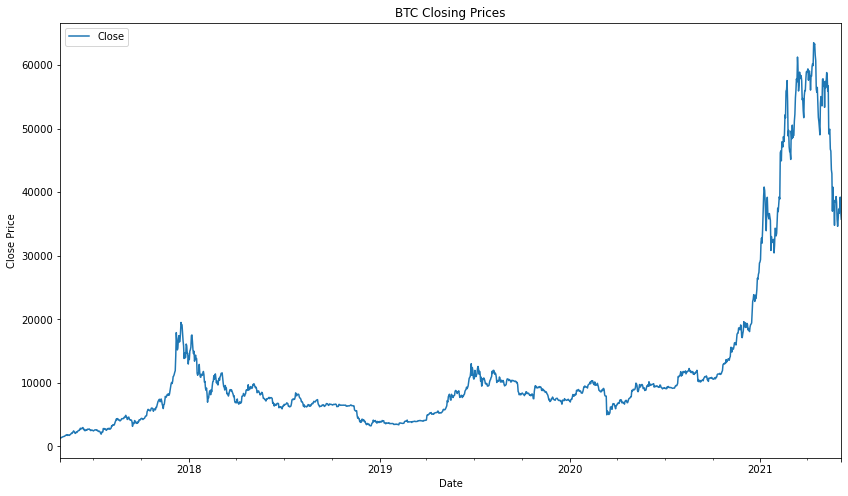

In [8]:
# plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title('BTC Closing Prices')
plt.ylabel('Close Price')
plt.show()

In [9]:
# train test split
prediction_days = 10
df_train = df.head(-prediction_days)
df_test = df.tail(prediction_days)
training_set = df_train.values
test_set = df_test.values
print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (1490, 1)
test_set.shape =  (10, 1)


In [10]:
# scale
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.00000000e+00],
       [8.53886015e-05],
       [5.05090237e-04],
       ...,
       [6.01243255e-01],
       [5.96358666e-01],
       [6.10702128e-01]])

In [11]:
training_set_scaled.shape

(1490, 1)

In [12]:
len(training_set_scaled)

1490

In [13]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
 
n_future = prediction_days #20  # Number of days you want to predict into the future
n_past = 50  # Number of past days you want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i-n_past:i, 0])
    y_train.append(training_set_scaled[i:i+n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train.shape, y_train.shape

((1431, 50), (1431, 10))

In [15]:
range(n_past, len(training_set_scaled) - n_future + 1)

range(50, 1481)

In [16]:
range(n_past, len(training_set_scaled)-7)

range(50, 1483)

In [17]:
for i in range(n_past, len(training_set_scaled) - n_future + 1):
    print('i={}, [{}, {})'.format(i, i-n_past, i))

i=50, [0, 50)
i=51, [1, 51)
i=52, [2, 52)
i=53, [3, 53)
i=54, [4, 54)
i=55, [5, 55)
i=56, [6, 56)
i=57, [7, 57)
i=58, [8, 58)
i=59, [9, 59)
i=60, [10, 60)
i=61, [11, 61)
i=62, [12, 62)
i=63, [13, 63)
i=64, [14, 64)
i=65, [15, 65)
i=66, [16, 66)
i=67, [17, 67)
i=68, [18, 68)
i=69, [19, 69)
i=70, [20, 70)
i=71, [21, 71)
i=72, [22, 72)
i=73, [23, 73)
i=74, [24, 74)
i=75, [25, 75)
i=76, [26, 76)
i=77, [27, 77)
i=78, [28, 78)
i=79, [29, 79)
i=80, [30, 80)
i=81, [31, 81)
i=82, [32, 82)
i=83, [33, 83)
i=84, [34, 84)
i=85, [35, 85)
i=86, [36, 86)
i=87, [37, 87)
i=88, [38, 88)
i=89, [39, 89)
i=90, [40, 90)
i=91, [41, 91)
i=92, [42, 92)
i=93, [43, 93)
i=94, [44, 94)
i=95, [45, 95)
i=96, [46, 96)
i=97, [47, 97)
i=98, [48, 98)
i=99, [49, 99)
i=100, [50, 100)
i=101, [51, 101)
i=102, [52, 102)
i=103, [53, 103)
i=104, [54, 104)
i=105, [55, 105)
i=106, [56, 106)
i=107, [57, 107)
i=108, [58, 108)
i=109, [59, 109)
i=110, [60, 110)
i=111, [61, 111)
i=112, [62, 112)
i=113, [63, 113)
i=114, [64, 114)
i=115

In [18]:
for i in range(n_past, len(training_set_scaled) - n_future + 1):
    print('i={}, [{}, {})'.format(i, i, i+n_future)) #  i,'-', i, '-', i+n_future)

i=50, [50, 60)
i=51, [51, 61)
i=52, [52, 62)
i=53, [53, 63)
i=54, [54, 64)
i=55, [55, 65)
i=56, [56, 66)
i=57, [57, 67)
i=58, [58, 68)
i=59, [59, 69)
i=60, [60, 70)
i=61, [61, 71)
i=62, [62, 72)
i=63, [63, 73)
i=64, [64, 74)
i=65, [65, 75)
i=66, [66, 76)
i=67, [67, 77)
i=68, [68, 78)
i=69, [69, 79)
i=70, [70, 80)
i=71, [71, 81)
i=72, [72, 82)
i=73, [73, 83)
i=74, [74, 84)
i=75, [75, 85)
i=76, [76, 86)
i=77, [77, 87)
i=78, [78, 88)
i=79, [79, 89)
i=80, [80, 90)
i=81, [81, 91)
i=82, [82, 92)
i=83, [83, 93)
i=84, [84, 94)
i=85, [85, 95)
i=86, [86, 96)
i=87, [87, 97)
i=88, [88, 98)
i=89, [89, 99)
i=90, [90, 100)
i=91, [91, 101)
i=92, [92, 102)
i=93, [93, 103)
i=94, [94, 104)
i=95, [95, 105)
i=96, [96, 106)
i=97, [97, 107)
i=98, [98, 108)
i=99, [99, 109)
i=100, [100, 110)
i=101, [101, 111)
i=102, [102, 112)
i=103, [103, 113)
i=104, [104, 114)
i=105, [105, 115)
i=106, [106, 116)
i=107, [107, 117)
i=108, [108, 118)
i=109, [109, 119)
i=110, [110, 120)
i=111, [111, 121)
i=112, [112, 122)
i=113,

In [19]:
training_set.shape

(1490, 1)

In [20]:
training_set[-1]

array([39294.199219])

In [21]:
#training_set[1993]

In [22]:
X_train.shape, y_train.shape

((1431, 50), (1431, 10))

In [23]:
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1431, 50, 1)

In [24]:
# building the RNN

activation = 'softsign' #'softsign' #'relu' #'sigmoid'
dropout = 0.2
neurons = 50

# Initialising the RNN
regressor = Sequential()

#regressor.add(LSTM(units=n_past, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 
regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation, input_shape=(X_train.shape[1], 1))) 
regressor.add(Dropout(dropout))

regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units=neurons, return_sequences=True, activation=activation))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units=neurons, return_sequences=False, activation=activation))
regressor.add(Dropout(dropout))

# Adding the output layer
regressor.add(Dense(units=prediction_days))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
#try also with RMSprop

# Model summary
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 50)            2

In [25]:
# including early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [26]:
# Fitting the RNN to the Training set
res = regressor.fit(X_train, y_train, batch_size=64, epochs=1000, validation_split=0.1
                    , callbacks=[early_stop]
                   ) 
# 100/32 / 250 , validation_split=0.1)
# the smaller the btach, the less overfitting, normally a number poewr of 2, 32,64,128, etc

Epoch 1/1000
21/21 [==============================] - 30s 302ms/step - loss: 0.0092 - accuracy: 0.0893 - val_loss: 0.4408 - val_accuracy: 0.2361
Epoch 2/1000
21/21 [==============================] - 3s 145ms/step - loss: 0.0035 - accuracy: 0.1130 - val_loss: 0.3610 - val_accuracy: 0.0764
Epoch 3/1000
21/21 [==============================] - 3s 145ms/step - loss: 0.0026 - accuracy: 0.1059 - val_loss: 0.3149 - val_accuracy: 0.0556
Epoch 4/1000
21/21 [==============================] - 3s 147ms/step - loss: 0.0021 - accuracy: 0.1000 - val_loss: 0.2508 - val_accuracy: 0.2361
Epoch 5/1000
21/21 [==============================] - 3s 148ms/step - loss: 0.0020 - accuracy: 0.1073 - val_loss: 0.2706 - val_accuracy: 0.0625
Epoch 6/1000
21/21 [==============================] - 3s 153ms/step - loss: 0.0018 - accuracy: 0.0979 - val_loss: 0.2042 - val_accuracy: 0.2014
Epoch 7/1000
21/21 [==============================] - 3s 158ms/step - loss: 0.0014 - accuracy: 0.1007 - val_loss: 0.1756 - val_accuracy

21/21 [==============================] - 3s 163ms/step - loss: 4.9349e-04 - accuracy: 0.1222 - val_loss: 0.0385 - val_accuracy: 0.2361
Epoch 57/1000
21/21 [==============================] - 3s 164ms/step - loss: 4.2992e-04 - accuracy: 0.1368 - val_loss: 0.0487 - val_accuracy: 0.2361
Epoch 58/1000
21/21 [==============================] - 3s 160ms/step - loss: 4.9190e-04 - accuracy: 0.1138 - val_loss: 0.0410 - val_accuracy: 0.2361
Epoch 59/1000
21/21 [==============================] - 3s 163ms/step - loss: 5.1689e-04 - accuracy: 0.1290 - val_loss: 0.0528 - val_accuracy: 0.2361
Epoch 60/1000
21/21 [==============================] - 3s 155ms/step - loss: 4.4383e-04 - accuracy: 0.1181 - val_loss: 0.0590 - val_accuracy: 0.2361
Epoch 61/1000
21/21 [==============================] - 3s 162ms/step - loss: 4.3462e-04 - accuracy: 0.1303 - val_loss: 0.0639 - val_accuracy: 0.2361
Epoch 62/1000
21/21 [==============================] - 3s 161ms/step - loss: 4.7460e-04 - accuracy: 0.1194 - val_loss: 0

21/21 [==============================] - 3s 157ms/step - loss: 2.9437e-04 - accuracy: 0.1632 - val_loss: 0.3067 - val_accuracy: 0.2292
Epoch 112/1000
21/21 [==============================] - 3s 161ms/step - loss: 2.9212e-04 - accuracy: 0.1420 - val_loss: 0.3251 - val_accuracy: 0.1736
Epoch 113/1000
21/21 [==============================] - 3s 160ms/step - loss: 3.1076e-04 - accuracy: 0.1275 - val_loss: 0.3081 - val_accuracy: 0.2500
Epoch 114/1000
21/21 [==============================] - 3s 157ms/step - loss: 2.9124e-04 - accuracy: 0.1288 - val_loss: 0.3389 - val_accuracy: 0.1944
Epoch 115/1000
21/21 [==============================] - 3s 157ms/step - loss: 2.7401e-04 - accuracy: 0.1583 - val_loss: 0.3265 - val_accuracy: 0.2292
Epoch 116/1000
21/21 [==============================] - 3s 159ms/step - loss: 2.8240e-04 - accuracy: 0.1272 - val_loss: 0.3613 - val_accuracy: 0.1667
Epoch 117/1000
21/21 [==============================] - 3s 156ms/step - loss: 2.8826e-04 - accuracy: 0.1437 - val_l

In [27]:
regressor.save('regressor.h5')

In [28]:
list(res.history)

['loss', 'accuracy', 'val_loss', 'val_accuracy']

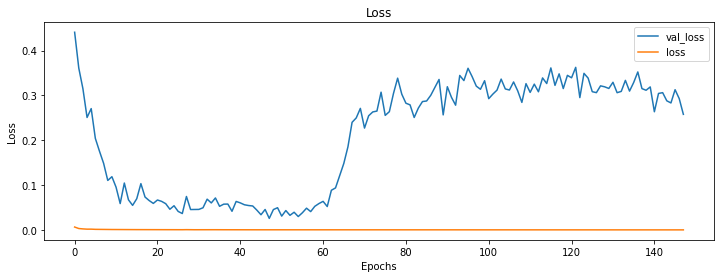

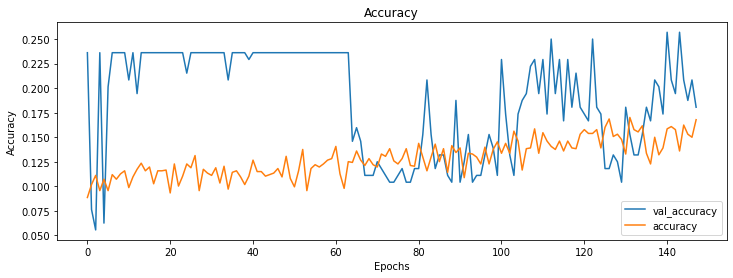

In [29]:
# Plotting Accuracy and Loss

results = res

history = results.history
plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history['val_accuracy'])
plt.plot(history['accuracy'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

y_pred:
 [[22514.2971156463], [22103.400203578163], [20742.03371399934], [20313.446897481273], [18456.855749121227], [17636.25916733956], [17560.56602144703], [17818.486496311765], [17524.070516111453], [15804.627556766782]]
y_true:
 [[43537.511719], [42909.402344], [37002.441406], [40782.738281], [37304.691406], [37536.632813], [34770.582031], [38705.980469], [38402.222656], [39294.199219]]


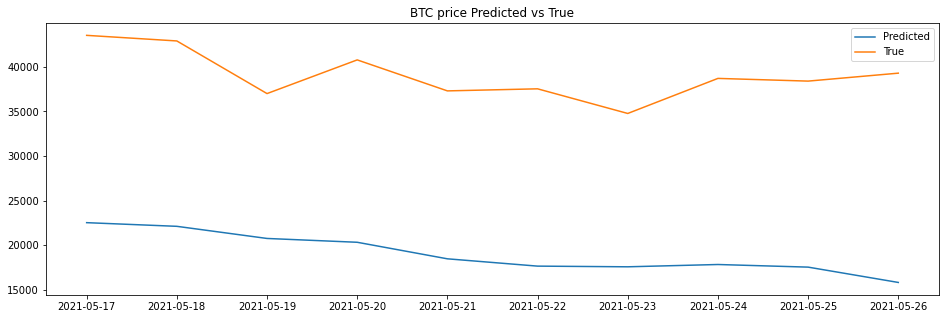

In [30]:
# Validation (validation with the last training days -> -15-15 DAYS)

# getting the predictions
y_pred = regressor.predict(X_train[-1].reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
y_true = sc.inverse_transform(y_train[-1].reshape(-1,1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df_train.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

y_pred:
 [[21573.3424642169], [21175.07219636222], [19760.36540924819], [19288.94103888457], [17398.274816326884], [16559.769638767353], [16431.781465754473], [16629.66468449523], [16304.814470044043], [14617.185538964175]]
y_true:
 [38436.96875, 35697.605469, 34616.066406, 35678.128906, 37332.855469, 36684.925781, 37575.179688, 39208.765625, 36894.40625, 35746.101563]


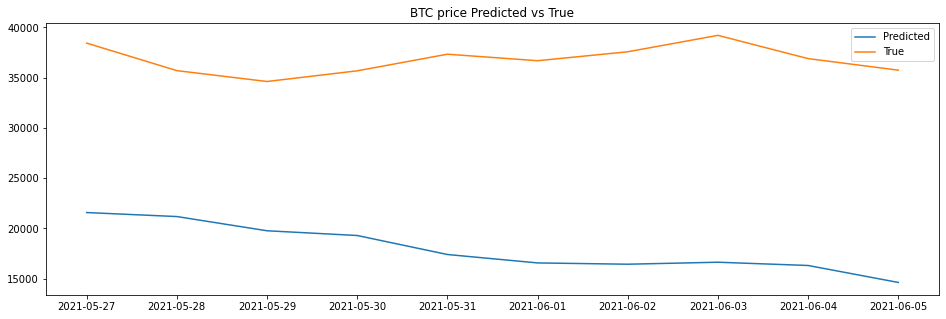

In [31]:
# Validation 2 (on the TEST SET -15 days)

# getting the predictions
x = df['Close'][-n_past-prediction_days:-prediction_days].values.reshape(-1,1)
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# getting the true values
y_true = df['Close'][-prediction_days:].values

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(16,5))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')

dates = df.index[-prediction_days:]
dates = [str(dates.date[i]) for i in range(len(dates))]
plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [32]:
# evaluation
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [33]:
mean_absolute_error(y_true, y_pred)

18813.179218393598

In [34]:
explained_variance_score(y_true, y_pred)
# Best possible score is 1.0, lower values are worse.

-3.219365272750082

y_pred:
 [[20439.872724820892], [20062.355893323504], [18628.267123942587], [18052.258259287282], [16208.847896725863], [15397.799600719583], [15212.831216882896], [15388.691477574564], [15028.659759071717], [13407.628823953732]]
y_true:
 [38436.96875, 35697.605469, 34616.066406, 35678.128906, 37332.855469, 36684.925781, 37575.179688, 39208.765625, 36894.40625, 35746.101563]


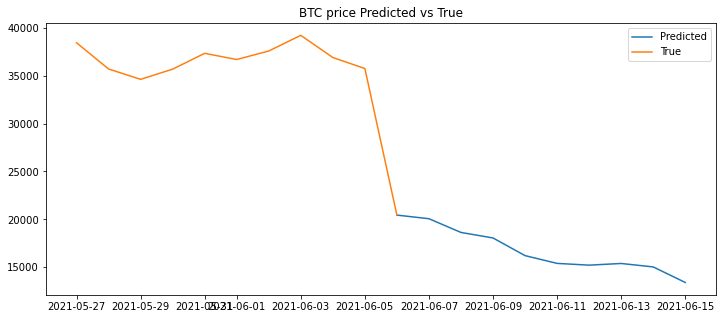

In [35]:
# Forecasting/Predicting

# getting the predictions
x = df['Close'][-n_past:].values.reshape(-1,1)
x = sc.transform(x)
y_pred = regressor.predict(x.reshape(1, n_past, 1)).tolist()[0]
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1,1))#.tolist()

# creating a DF of the predicted prices
y_pred_df = pd.DataFrame(y_pred, 
                         index=pd.date_range(start=df.index[-1]+datetime.timedelta(days=1),
                                             periods=len(y_pred), 
                                             freq="D"), 
                         columns=df.columns)

# getting the true values
y_true_df = df.tail(prediction_days)

# linking them
y_true_df = y_true_df.append(y_pred_df.head(1))

print('y_pred:\n', y_pred.tolist())
print('y_true:\n', y_true.tolist())

# plotting the results
plt.figure(figsize=(12,5))
plt.plot(y_pred_df, label='Predicted')
plt.plot(y_true_df, label='True')

#dates = df.index[-prediction_days:]
#dates = [str(dates.date[i]) for i in range(len(dates))]
#plt.xticks(range(prediction_days),dates)

plt.title('BTC price Predicted vs True')
plt.legend()
plt.show()

In [36]:
regressor.save('regressor.h5')
#loaded_regressor = load_model('regressor.h5')
#loaded_regressor.predict(new_x)

**Improving the RNN**

Here are different ways to improve the RNN model:

Getting more training data: we trained our model on the past 5 years of the Google Stock Price but it would be even better to train it on the past 10 years.

Increasing the number of timesteps: the model remembered the stock prices from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 timesteps (3 months). You could try to increase the number of timesteps, by choosing for example 120 timesteps (6 months).

Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

Adding more neurones in the LSTM layers: we highlighted the fact that we needed a high number of neurones in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurones in each of our 4 LSTM layers. You could try an architecture with even more neurones in each of the 4 (or more) LSTM layers.

**Evaluating the RNN**

As seen in the practical lectures, the RNN we built was a regressor. Indeed, we were dealing with Regression because we were trying to predict a continuous outcome (the Google Stock Price). For Regression, the way to evaluate the model performance is with a metric called RMSE (Root Mean Squared Error). It is calculated as the root of the mean of the squared differences between the predictions and the real values.

However for our specific Stock Price Prediction problem, evaluating the model with the RMSE does not make much sense, since we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price. We want to check if our predictions follow the same directions as the real stock price and we don’t really care whether our predictions are close the real stock price. The predictions could indeed be close but often taking the opposite direction from the real stock price.

Nevertheless if you are interested in the code that computes the RMSE for our Stock Price Prediction problem, please find it just below:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
Then consider dividing this RMSE by the range of the Google Stock Price values of January 2017 (that is around 800) to get a relative error, as opposed to an absolute error. It is more relevant since for example if you get an RMSE of 50, then this error would be very big if the stock price values ranged around 100, but it would be very small if the stock price values ranged around 10000.

Enjoy Deep Learning!